# Install Dependencies

In [ ]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

In [ ]:
!pip install opencv-python==4.5.1.48

# Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('Data','Images')
number_images = 50

In [ ]:
cap = cv2.VideoCapture(0)

for imgnum in range(number_images):
    print(f'Collecting image {imgnum}')
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    time.sleep(0.5)

cap.release()

# Annotate Images with LabelMe

In [ ]:
!labelme

# Partition data and move the matching labels

- manually split data into 200 images train, 45 val and 40 test

In [ ]:
# Move the matching labels

for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('Data', folder, 'Images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('Data','Labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)  

# Build image loading function

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
images = tf.data.Dataset.list_files('Data\\train\\Images\\*.jpg')

In [5]:
images.as_numpy_iterator().next()

b'Data\\train\\Images\\b779cbcf-367f-11ed-8e68-3c2c30f4fd65.jpg'

In [6]:
images = images.map(load_image)

In [7]:
images.as_numpy_iterator().next()

array([[[109,  70,  55],
        [101,  64,  48],
        [ 99,  62,  46],
        ...,
        [125, 141, 156],
        [131, 144, 161],
        [129, 142, 159]],

       [[100,  61,  44],
        [ 93,  56,  38],
        [ 94,  59,  40],
        ...,
        [116, 134, 148],
        [120, 136, 152],
        [121, 137, 153]],

       [[ 96,  60,  38],
        [ 94,  59,  37],
        [ 94,  59,  39],
        ...,
        [114, 133, 147],
        [113, 135, 149],
        [116, 138, 152]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 77,  71,  57],
        [ 80,  74,  62],
        [ 84,  78,  64]],

       [[  1,   1,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 86,  74,  60],
        [ 88,  76,  64],
        [ 90,  78,  64]],

       [[  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0],
        ...,
        [ 91,  77,  64],
        [ 99,  83,  70],
        [101,  85,  72]]

In [8]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [9]:
image_generator = images.batch(4).as_numpy_iterator()

In [62]:
plot_images = image_generator.next()

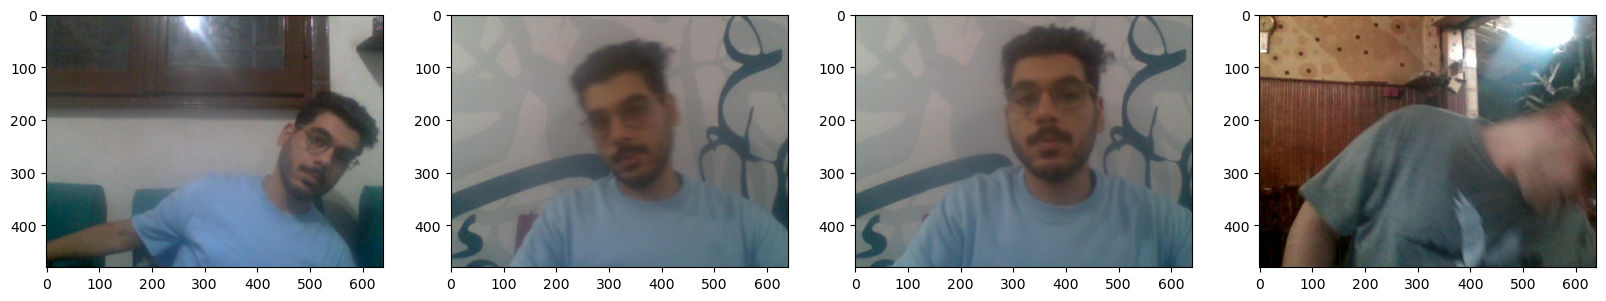

In [63]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# **Augmentation using Albumentations**

## - Setup Albumentations Transform Pipeline

In [5]:
import albumentations as alb

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5),
                         alb.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5)
                        ], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

## - Load a Test Image and Annotation with OpenCV and JSON

In [66]:
img = cv2.imread(os.path.join('Data','train', 'Images','20be9b52-3680-11ed-bd1f-3c2c30f4fd65.jpg'))

In [67]:
img.shape

(480, 640, 3)

In [68]:
with open(os.path.join('Data', 'train', 'Labels', '20be9b52-3680-11ed-bd1f-3c2c30f4fd65.json'), 'r') as f:
    label = json.load(f)

In [69]:
label['shapes'][0]['points']

[[121.53807106598984, 70.05076142131979],
 [328.1370558375635, 317.76649746192896]]

## - Extract Coordinates and Rescale to Match Image Resolution

In [70]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [71]:
coords

[121.53807106598984, 70.05076142131979, 328.1370558375635, 317.76649746192896]

In [72]:
coords = list(np.divide(coords, [640,480,640,480]))

In [73]:
coords

[0.18990323604060913,
 0.14593908629441624,
 0.5127141497461929,
 0.6620135363790187]

## - Apply Augmentations and View Results

In [74]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [75]:
augmented['bboxes'][0][2:]

(0.6069712351945855, 0.6461477721376199)

In [76]:
augmented['bboxes']

[(0.1478623801466441,
  0.09566835871404399,
  0.6069712351945855,
  0.6461477721376199)]

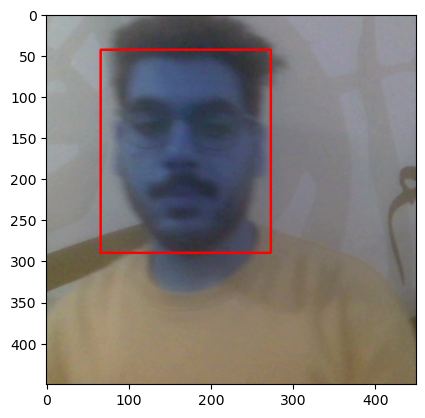

In [77]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('Data', partition, 'Images')):
        img = cv2.imread(os.path.join('Data', partition, 'Images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('Data', partition, 'Labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(20):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'Images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

# Load Augmented Images to Tensorflow Dataset

In [4]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\Images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [5]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\Images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\Images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

# Prepare labels

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [8]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\Labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\Labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\Labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.579 , 0.2678, 0.983 , 0.8477], dtype=float16))

# Combine Label and Image Samples

In [12]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(6420, 6420, 800, 800, 880, 880)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(7000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
len(train)

803

In [15]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [16]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

# Plot sample from data

In [90]:
data_samples = val.as_numpy_iterator()

In [91]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


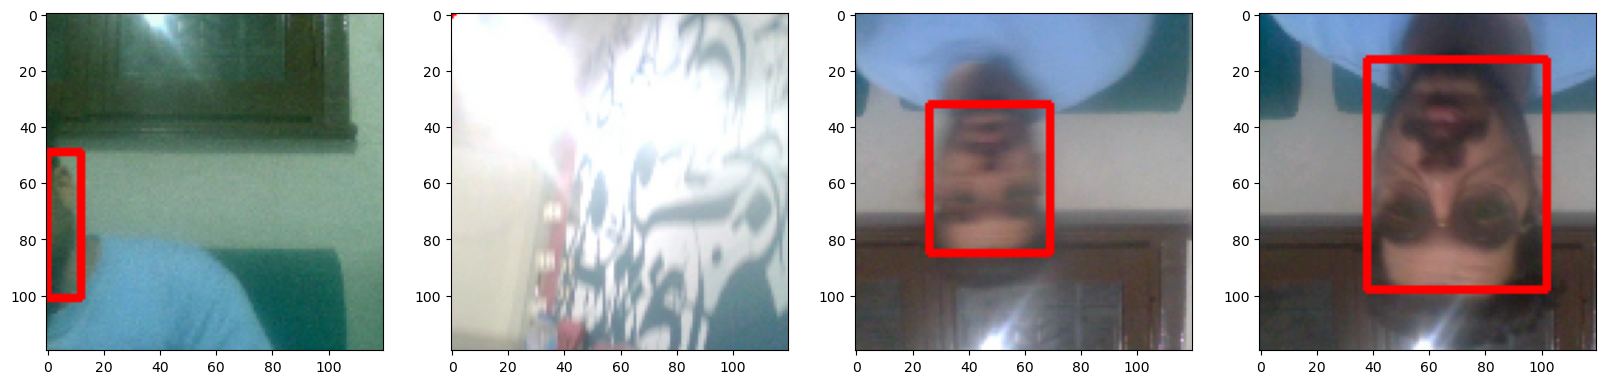

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Model

In [17]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [18]:
vgg = VGG16(include_top=False)

In [19]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## - Build instance from the model

In [20]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

## - Test the model

In [21]:
facetracker = build_model()

In [22]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [24]:
X, y = test.as_numpy_iterator().next()

In [25]:
X.shape

(8, 120, 120, 3)

In [26]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 2s 2s/step


In [27]:
classes, coords

(array([[0.4417475 ],
        [0.53470814],
        [0.49858135],
        [0.4954128 ],
        [0.44231987],
        [0.46656057],
        [0.41356406],
        [0.43194795]], dtype=float32),
 array([[0.60694647, 0.5525495 , 0.38975844, 0.35630035],
        [0.5743355 , 0.6202318 , 0.4101641 , 0.34346408],
        [0.58132607, 0.6499983 , 0.45673084, 0.35932305],
        [0.547029  , 0.61012715, 0.48800835, 0.361265  ],
        [0.5402096 , 0.6149073 , 0.3799981 , 0.37320805],
        [0.6101389 , 0.54901236, 0.39148393, 0.36425006],
        [0.48243728, 0.6076526 , 0.34904024, 0.32576582],
        [0.58946043, 0.5286561 , 0.41513062, 0.34915426]], dtype=float32))

# Define Losses and Optimizers

## - Define Optimizer and LR

In [23]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

## - Create Localization Loss and Classification Loss

In [25]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [26]:
classification_loss = tf.keras.losses.BinaryCrossentropy()
regression_loss = localization_loss

## - Test loss fumctions

In [27]:
classification_loss(y[0], classes)

NameError: name 'y' is not defined

In [ ]:
regression_loss(y[1], coords)

# Train Neural Network

In [28]:
class FaceTracker(Model): 
    def __init__(self, tracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = tracker

    def compile(self, opt, classificationloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classificationloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [29]:
model = FaceTracker(facetracker)

In [30]:
model.compile(opt, classification_loss, regression_loss)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val)

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# Save model

In [32]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [33]:
facetracker = load_model('facetracker.h5')

# Make Predictions

In [114]:
test_data = test.as_numpy_iterator()

In [115]:
test_sample = test_data.next()

In [116]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 304ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


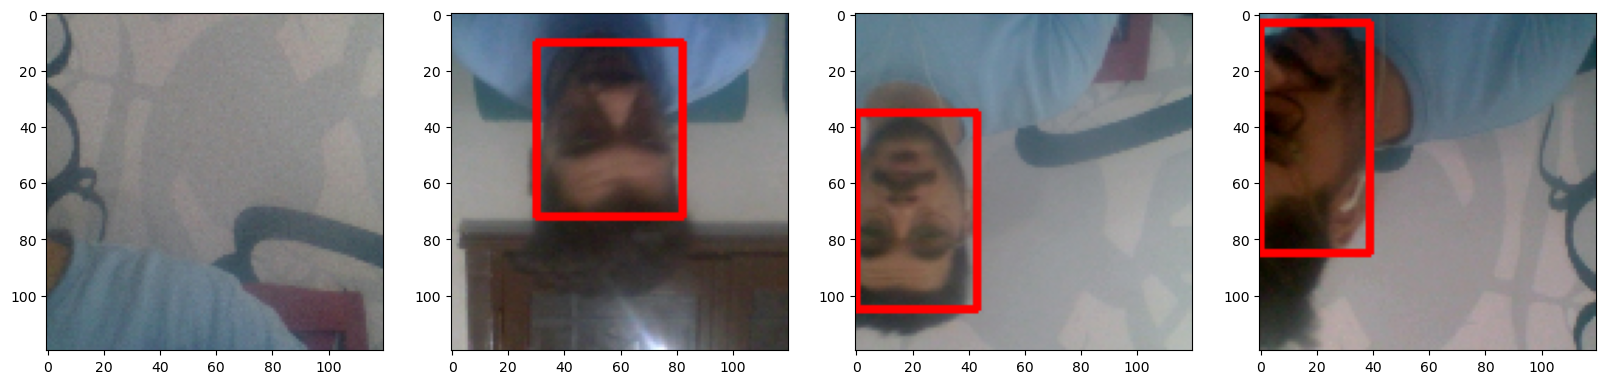

In [117]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [36]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.9: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 52ms/step
